Big data is big at the moment. Everyone and their nephew are aware of data and its superpower. However, most of this is data valuable for businesses, data that can be represented in a dataframe a.k.a. database table.

| id | customer_id | product_id | order_amount | profit |
|:--:|:--------:|:-------:|:-:|:-:|
| 1  | 5340     | 12408   | 3 | 100 |
| 2  | 235      | 9401    | 8 | 90 |
<br>*Business data*

To store this data, we have great relational databases, columnar databases, managed columnar autoscaling databases, etcetera. We can even build streaming pipelines to reach the ultimate goal of optimizing clickthrough rates in realtime.

Science data, however, does not always fit in this paradigm. More often than not, this data is best represented as large multi-dimensional arrays, especially earth observation and weather/climate simulation data. Some argue that with the advent of machine learning and data science, more and more of this computation will move into the database, and this computation is [best defined on arrays](https://www.datanami.com/2014/04/09/array_databases_the_next_big_thing_in_data_analytics_/).

![Interesting data](/dask-array.png)
<br>*Interesting data*

We are not completely at a loss, luckily, as there are some solutions to querying this kind of data effectively. In this series we will look at multiple [array databases](https://www.wikiwand.com/en/Array_DBMS), and do a similar set of operations with them, to get a feeling for how they work, and what their strong and weak points are.

After a bit of searching I compiled this list of interesting options for storing array data:
- Store as file or blobs, query with [xarray](http://xarray.pydata.org/) + Dask (this post)
- [SciDB](http://paradigm4.github.io/SciDB-Py/), a custom array database (future post)
- [PostGIS raster](https://postgis.net/docs/using_raster_dataman.html), support for rasters in PostGIS/Postgres (future post)
- [TileDB](https://tiledb.com/), a modern way to analyze array data using Dask as compute backend and blob storage to store array (meta)data (future post)
- [rasdaman](http://www.rasdaman.org/), the original array database, seems to have been around for a while (possibly future post)

We'll use temperature data from the ERA5 reanalysis as representative usecase. I intend to make a comparison post at the end of this series going over some of the strong points and weaknesses of the different systems.

<!-- TEASER_END -->

## Downloading ERA5 hourly temperature data

This dataset can be ordered and downloaded [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form) (after creating an account), make sure to choose "reanalysis", "2m temperature", year 2018, all months/days/hours, and export as NetCDF. Save it as `data/era5-2018-t2m-hourly.nc` if you want to follow along with this notebook. Total dataset size is 17GB.

## Array DB comparison: xarray

[xarray](http://xarray.pydata.org/) is an incredible package that adds the superpower of metadata to numpy. It is modelled closely after NetCDF, which is a file format and corresponding library that can store and retrieve this metadata along with the data, and climate data saved in this format is usually standardized using [cfconventions.org](http://cfconventions.org/), which allows xarray and other libraries to infer what dimensions mean and plot nice images out-of-the-box. Hence, our data loading step is straightforward and provides a great starting point for our comparison series.

In [22]:
# Using these versions of these libraries. Probably not critical but still nice for reproducibility
!python --version && pip freeze | grep -E "(xarray|pandas|matplotlib|pyproj|numpy|dask|scipy)"

Python 3.7.5
dask==2.8.0
matplotlib==3.1.1
numpy==1.17.4
pandas==0.25.3
pandas-gbq==0.11.0
pyproj==2.4.1
scipy==1.2.0
xarray==0.14.0


In [1]:
import xarray as xr

ds_path = "data/era5-2018-t2m-hourly.nc"

!echo "File size:" && numfmt --to=iec-i --suffix=B --format="%.3f" $(stat -c "%s" {ds_path})

# Pass chunks kwarg to divide in chunks and process in parallel with Dask
# e.g. chunks={"latitude": "auto", "longitude": "auto", "time": 100}
ds = xr.open_dataset(ds_path)
ds

File size:
16,941GiB


<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 8760)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-12-19 12:32:20 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

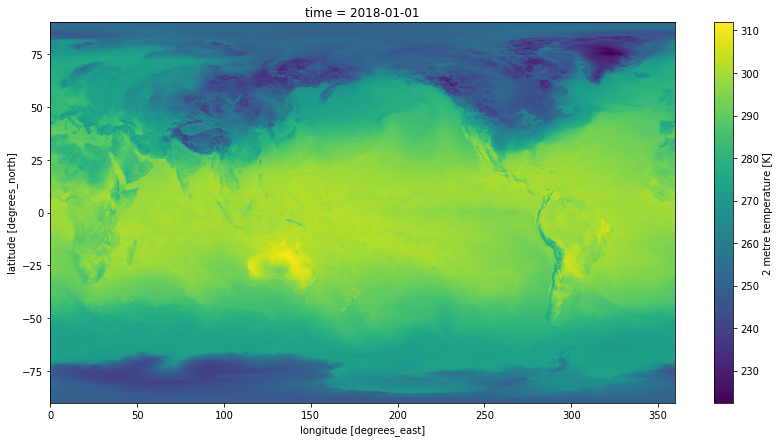

In [2]:
FIGSIZE = (14, 7)
ds.t2m.isel(time=0).plot(figsize=FIGSIZE);

## Extract timeseries

This is relatively easy and very fast, as this can be read relatively quickly from the NetCDF file.

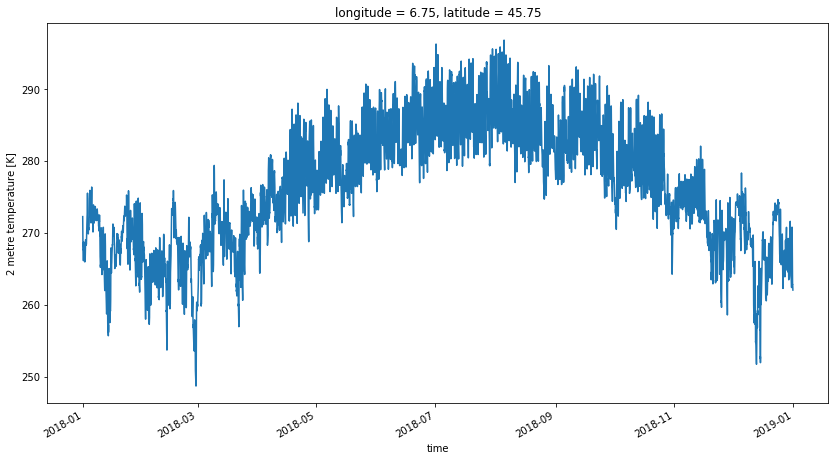

In [3]:
# Mont Blanc
LON = 6.865575
LAT = 45.832119

# We use the nearest-neighbor selection option
ds.sel(longitude=LON, latitude=LAT, method="nearest").t2m.plot(figsize=FIGSIZE);

Often we also need to interpolate. We can do that quite easily as xarray makes use of the [scipy.interpolate](https://docs.scipy.org/doc/scipy/reference/interpolate.html) module and will by default interpolate linearly. We'll omit a plot for brevity.

In [4]:
import pandas as pd

# Just showing the time index for brevity
ds.sel(longitude=LON, latitude=LAT, method="nearest").t2m.interp({
    "time": pd.date_range(start=ds.time.min().values, end=ds.time.max().values, freq="15T")
}).time.values[:3]

array(['2018-01-01T00:00:00.000000000', '2018-01-01T00:15:00.000000000',
       '2018-01-01T00:30:00.000000000'], dtype='datetime64[ns]')

## Aggregation

Another common operation is aggregation. This is quite easy, and relatively fast, as xarray can read just parts of the NetCDF file.

CPU times: user 3.65 s, sys: 1.89 s, total: 5.54 s
Wall time: 4.92 s


Text(0.5, 1.0, 'Average temperature in 2018')

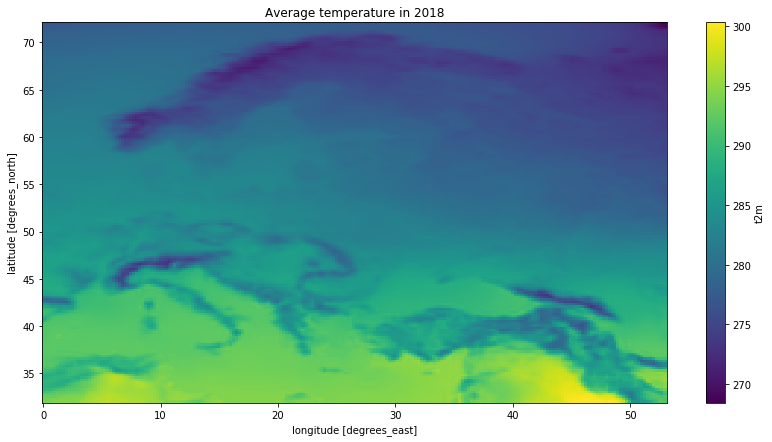

In [5]:
%%time
import matplotlib.pyplot as plt

# Europe. Starting from lon=0 to avoid having to ds.roll(), although that would be little effort
LAT_MIN = 32
LAT_MAX = 72
LON_MIN = 0
LON_MAX = 53

# .sel() is xarray's solution to get around Python not supporting [lon=5:lon=6,lat=2:lat=9]
ds.t2m.sel(longitude=slice(LON_MIN, LON_MAX), latitude=slice(LAT_MAX, LAT_MIN)
).mean(dim="time"
).plot(figsize=FIGSIZE)
plt.title("Average temperature in 2018");

## Reprojection

Another interesting operation is to reproject from one spatial coordinate system to another. We will reproject from ERA5's native regular lat/lon grid (with [spherical datum](https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference)) to transverse mercator, the same projection used for the UTM coordinate system, which allows more accuracy close to its offset longitude. This was chosen as it makes the pixels much more "square", so makes the data more interesting for e.g. convolutional neural networks which rely on that property as their kernels are the same all over the grid.

In [6]:
# See pyproj.github.io for explanation on coordinate systems and transforms
from pyproj import CRS, Transformer

# Approx. the sphere used for ERA5
crs1 = CRS.from_epsg(4035)
crs1

<Geographic 2D CRS: EPSG:4035>
Name: Unknown datum based upon the Authalic Sphere
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree minute second hemisphere)
- Long[east]: Geodetic longitude (degree minute second hemisphere)
Area of Use:
- name: Not specified
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: Not specified (based on Authalic Sphere)
- Ellipsoid: Sphere
- Prime Meridian: Greenwich

In [7]:
# Transverse mercator with its offset longitude at 10 degrees east
crs2 = CRS.from_proj4("+proj=tmerc +lat_0=0 +lon_0=10")
crs2

<Projected CRS: +proj=tmerc +lat_0=0 +lon_0=10 +type=crs>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

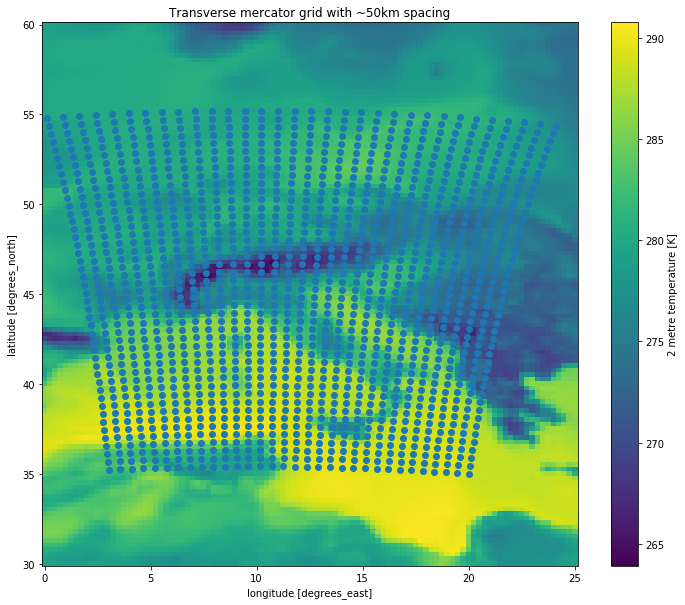

In [8]:
import numpy as np

# Instantiate pyproj's abstraction for coordinate transforms from one CRS to another.
# Specify always_xy to use lon/lat aka x/y order instead of lat/lon
transformer = Transformer.from_crs(crs1, crs2, always_xy=True)

# Part of Europe
LAT_MIN = 35
LAT_MAX = 55
LON_MIN = 0
LON_MAX = 20

# Left upper bound
lu = transformer.transform(LON_MIN, LAT_MAX)
# Right lower bound
rl = transformer.transform(LON_MAX, LAT_MIN)

# Coordinates of new grid in transverse mercator. It will be square in this projection
x_tm = np.arange(rl[0], lu[0], -50000)
y_tm = np.arange(rl[1], lu[1], 50000)

# Go from 1D lists to 2D grids
lon_grid, lat_grid = np.meshgrid(
    x_tm,
    y_tm,
)

# Easily do the inverse transform
lon_grid, lat_grid = transformer.transform(lon_grid, lat_grid, direction="INVERSE")

# Plot the data and the resulting grid
BUFFER = 5

ds.t2m.sel(longitude=slice(LON_MIN-BUFFER, LON_MAX+BUFFER), latitude=slice(LAT_MAX+BUFFER, LAT_MIN-BUFFER)
).isel(time=5).plot(figsize=(12, 10))

plt.plot(*np.stack([lon_grid.ravel(), lat_grid.ravel()]), 'o')

plt.title("Transverse mercator grid with ~50km spacing");

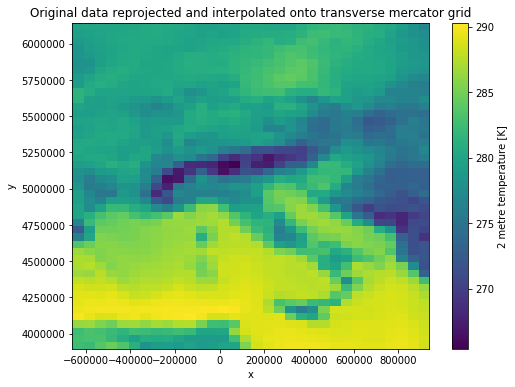

In [9]:
# xarray supports very advanced interpolation with very little code as it accepts DataArrays where
# you can indicate the coords in crs1 as data and new crs2 coords as coords
ds.t2m.isel(time=5).interp(
    coords=dict(
        longitude=xr.DataArray(lon_grid, dims=["y", "x"], coords=[y_tm, x_tm]),
        latitude=xr.DataArray(lat_grid, dims=["y", "x"], coords=[y_tm, x_tm]),
    ),
    assume_sorted=False
).plot(figsize=(8,6))
plt.title("Original data reprojected and interpolated onto transverse mercator grid");

Woah! That went quite deep. We see that, having the full power of numpy, proj4 and xarray, we can reproject to any coordinate system we like.

## Convolution

We have seen that we can extract timeseries and reproject, but we haven't done any operations over adjacent pixels like convolution with a kernel.

This is an expensive operation, to parallelize this with Dask we'll chunk the time dimension. We will keep the lat/lon dimensions in one piece as window operations over chunked dimensions become more difficult ([supported by Dask](https://docs.dask.org/en/latest/array-overlap.html), but not directly supported by `xarray.apply_ufunc`) and we don't care about the exact chunking anyway, just that the work is divided over multiple workers.

We first start a Dask Distributed cluster that allows us to more easily distribute work over one or multiple machines (and is in general a better choice than the default thread-based scheduler). It also has a built-in diagnostic dashboard that lets us see all tasks executed and is generally mesmerizing to look at.

In [10]:
from dask.distributed import Client

dd_client = Client()
dd_client

<Client: 'tcp://127.0.0.1:44545' processes=4 threads=8, memory=33.52 GB>

Dask lets us nicely visualize the underlying data. Here we chunk the array in the time dimension, letting Dask choose [chunks of approx. 100MB](https://docs.dask.org/en/latest/array-best-practices.html#select-a-good-chunk-size).

In [11]:
# We let Dask choose the chunk size in time dimension but keep lat/lon together so we can apply a function along those dims
ds = ds.chunk({"time": "auto", "latitude": -1, "longitude": -1})
ds.t2m.data

dask.array<xarray-t2m, shape=(8760, 721, 1440), dtype=float32, chunksize=(30, 721, 1440), chunktype=numpy.ndarray>

We now apply the [scipy.ndimage.filters.gaussian_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html#scipy.ndimage.gaussian_filter), using [xarray.apply_ufunc](http://xarray.pydata.org/en/stable/generated/xarray.apply_ufunc.html#xarray-apply-ufunc) to couple the `xarray.Dataset`'s metadata (stemming from the NetCDF file) to the pure-numpy function. This is the power of metadata in action.

We also show the task graph generated by Dask for a 3-chunk array, which should make the point that Dask plans and distributes work using its [directed acyclic graph representation](https://docs.dask.org/en/latest/spec.html), which is actually encoded in a very readable normal Python dictionary.

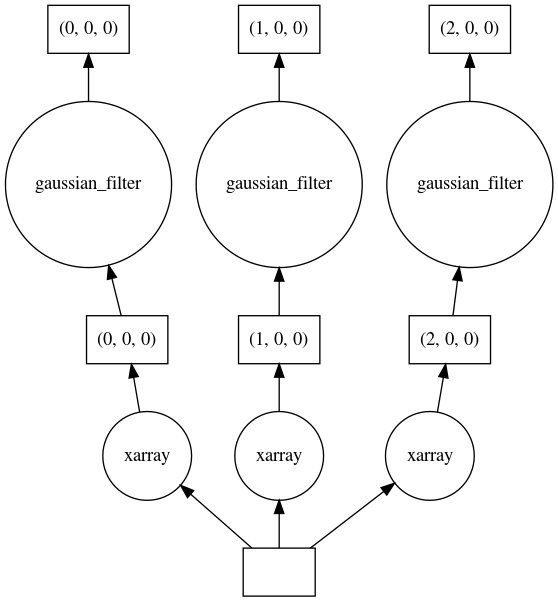

In [12]:
from scipy.ndimage.filters import gaussian_filter

def blur(da, sigma=10):
    return xr.apply_ufunc(
        gaussian_filter,
        da,
        kwargs={"sigma": sigma},
        input_core_dims=[["latitude", "longitude"]],
        output_core_dims=[["latitude", "longitude"]],
        dask="parallelized",
        output_dtypes=[float]
    )

# Use a little trickery to avoid showing all the NetCDF chunks
blur(ds.t2m.isel(time=slice(0,3)).compute().chunk({"time": 1})).data.visualize()

CPU times: user 25 s, sys: 2.61 s, total: 27.7 s
Wall time: 6min 2s


Text(0.5, 1.0, 'The variance of temperature per grid point compared to its gaussian-weighted neighborhood over 2018')

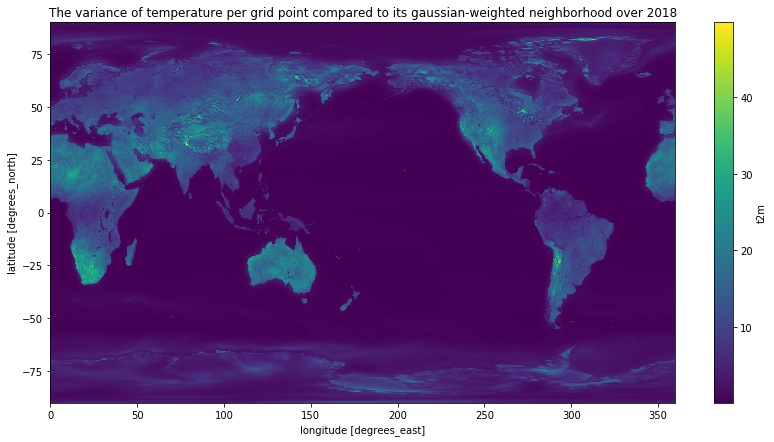

In [13]:
%%time
da = ds.t2m
(blur(da) - da).var(dim="time").plot(figsize=FIGSIZE)
# Interesting to see is that primarily the dry regions show up
plt.title("The variance of temperature per grid point compared to its gaussian-weighted neighborhood over 2018");

We have just done quite advanced computation on 36GB of (uncompressed) data, using all cores and easily allowing parallelization to many more machines, and all this with just a few GB of RAM. That is quite impressive, especially with this little code.

## NetCDF + xarray + Dask
So we've seen the powers of these libraries combined, let's list some advantages and disadvantages.

Pro:
- Very easy to use from Python, arbitrary computations possible
- Reading from NetCDF stored in normal file system is very fast
- Can easily output pretty much any format that has a Python library (Avro, JSON, pickle etc.)
- Can scale to arbitrary cluster using Dask (if using shared filesystem with NetCDF or blob storage with Zarr)

Con:
- User must (build an abstraction to) manage compute
- Appending to a NetCDF file is difficult, insert not possible, see below
- NetCDF supports compression but that is [not parallelizable](http://xarray.pydata.org/en/stable/io.html#chunk-based-compression) with this stack
- Will slow down if metadata is not centralized (many small files), see below

## Zarr + xarray + Dask
One problem with NetCDF is that it needs block storage (filesystem) and cannot directly handle blob storage (standard cloud object storage). The reason one would want this is that blob storage is about 2x cheaper than block storage, and is more easily accessed while scaling very well. Block storage or a shared filesystem must always be attached/mounted to the machine that wants access. [Zarr](http://xarray.pydata.org/en/stable/io.html#zarr) does allow efficiently using blob storage, and the good news is that NetCDF might [support Zarr as backend](https://www.unidata.ucar.edu/blogs/news/entry/netcdf-and-native-cloud-storage) sometime in the future.

The bad news is that zarr is not super mature yet, reading multiple files is not supported yet by `xarray.open_mfdataset` (it still involves using `dask.delayed` directly to parallelize), but it does do a good job in being one of the first blob-storage-native array storage formats.

## The need for speed: central metadata
At this point I should clarify a bit more what I'm looking for, which is an *array database*, and in my opinion modern databases do a great job at abstracting away a number of things:
- Storage: user does not care about storage
- Computation: user just asks a question using a query, does not care about compute
- Transactions: user does not care about consistency and race conditions

However, the combination of NetCDF/Zarr with xarray and dask does not abstract this away, it's all very much visible to the user.

The reason that NetCDF is fast is because the metadata that describes the coordinates and the place of every data block is central. If we spread the data out over many files, this metadata must first be collected from many places and the coordinates merged before we can do any computation. Thus, one big file (e.g. per year) is much preferred over many small files (per day or even hour).

When making few big NetCDF files, appending is important, which is possible in NetCDF to dimensions marked as "infinite", and also possible in Zarr in limited ways (same dimensions for all data variables). Inserting is, however, not possible in both formats as far as I know, requiring re-writing the entire file. That is a bit annoying and requires very careful data manipulation.

It would be possible to build a system that abstracts all this away for the user, so that one can just ask "give me the timeseries of average temperature for this region" and not have to worry about compute, but there is quite a lot of work involved there. Still, the integration with the Python ecosystem and easy learning curve make it a very powerful set of tools.